# Sample Final Plotly Graphics

In [62]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np
import pickle
import optuna
import plotly.graph_objs as go

## Load data

In [63]:
# Historical data from Github
url = 'https://raw.githubusercontent.com/ijyliu/mcbroken-daily-historical/refs/heads/main/mcbroken_daily_most_recent_on_20250215.csv'

# Read the data
historical_data = pd.read_csv(url)
historical_data

# Drop entry for 2025-02-15 - this will come from the more recent S3 data
historical_data = historical_data[historical_data['date'] != '2025-02-15']

In [64]:
# More recent data from S3
s3_url = 'https://mcbroken-bucket.s3.us-west-1.amazonaws.com/updated-mcbroken.csv'

# Read the data
recent_data = pd.read_csv(s3_url)
recent_data

,total_machines,date,datetime,broken_machines
0,12119,2025-02-22,2025-02-22T19:40:17.540489,1184
1,11867,2025-02-16,2025-02-16T19:40:17.382296,1283
2,11835,2025-02-19,2025-02-19T19:40:17.449094,1190
3,11907,2025-02-21,2025-02-21T19:40:17.369561,1110
4,11832,2025-02-18,2025-02-18T19:40:22.306247,1359
5,11570,2025-02-17,2025-02-17T19:40:17.357708,1364
6,11773,2025-02-15,2025-02-15T19:40:17.269596,1107
7,12253,2025-02-23,2025-02-23T19:40:17.424052,1460
8,11990,2025-02-20,2025-02-20T19:40:24.688253,1207


In [65]:
lim_hist = historical_data[['date', 'broken_machines', 'total_machines']]
lim_recent = recent_data[['date', 'broken_machines', 'total_machines']]
df = pd.concat([lim_hist, lim_recent], axis=0).sort_values('date').reset_index(drop=True)
# Rename broken_machines to "Broken Machines" and total_machines to "Total Machines", and date to "Date"
df = df.rename(columns={'broken_machines': 'Broken Machines', 'total_machines': 'Total Machines', 'date': 'Date'})
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Add percent broken
df['Percent Broken'] = df['Broken Machines'] / df['Total Machines'] * 100
# Daily revenue losses at $625 per machine per day
# https://www.dailymail.co.uk/sciencetech/article-14019935/McDonalds-fans-rejoice-company-wins-legal-battle-fix-one-lifes-greatest-nuisances.html
df['Revenue Losses'] = df['Broken Machines'] * 625
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses
0,2020-10-25,354,6818,5.192138,221250
1,2020-10-26,373,6844,5.450029,233125
2,2020-10-27,427,7488,5.702457,266875
3,2020-10-28,391,8294,4.714251,244375
4,2020-10-29,374,7461,5.012733,233750
...,...,...,...,...,...
1449,2025-02-19,1190,11835,10.054922,743750
1450,2025-02-20,1207,11990,10.066722,754375
1451,2025-02-21,1110,11907,9.322247,693750
1452,2025-02-22,1184,12119,9.769783,740000


In [66]:
# Limit to most recent 30 days for display
df = df.sort_values('Date', ascending=True).tail(30).reset_index(drop=True)
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses
0,2025-01-25,1371,13277,10.326128,856875
1,2025-01-26,1553,13446,11.549903,970625
2,2025-01-27,1660,13135,12.637990,1037500
3,2025-01-28,1507,12966,11.622706,941875
4,2025-01-29,1375,12984,10.589957,859375
5,2025-01-30,1302,12797,10.174260,813750
6,2025-01-31,1097,11466,9.567417,685625
7,2025-02-01,1142,11757,9.713362,713750
8,2025-02-02,1292,11835,10.916772,807500
9,2025-02-03,1401,11866,11.806843,875625


## Prophet

In [67]:
# Load model from ../Forecasts/Models/Prophet.pkl
with open('../Forecasts/Models/Prophet.pkl', 'rb') as f:
    m = pickle.load(f)

In [68]:
# Retrieve outlier_cols
outlier_cols = list(m.extra_regressors.keys())
outlier_cols

['Outlier_2020-12-14 00:00:00',
 'Outlier_2021-07-07 00:00:00',
 'Outlier_2021-07-08 00:00:00',
 'Outlier_2021-07-09 00:00:00',
 'Outlier_2021-07-10 00:00:00',
 'Outlier_2021-07-11 00:00:00',
 'Outlier_2021-07-12 00:00:00',
 'Outlier_2021-07-13 00:00:00',
 'Outlier_2021-07-14 00:00:00',
 'Outlier_2021-07-22 00:00:00',
 'Outlier_2021-08-04 00:00:00',
 'Outlier_2021-10-01 00:00:00',
 'Outlier_2021-10-06 00:00:00',
 'Outlier_2021-12-07 00:00:00',
 'Outlier_2021-12-22 00:00:00',
 'Outlier_2022-07-08 00:00:00',
 'Outlier_2022-08-19 00:00:00',
 'Outlier_2022-09-09 00:00:00',
 'Outlier_2022-09-28 00:00:00',
 'Outlier_2022-10-12 00:00:00',
 'Outlier_2022-10-13 00:00:00',
 'Outlier_2022-10-14 00:00:00',
 'Outlier_2022-10-15 00:00:00',
 'Outlier_2022-10-16 00:00:00',
 'Outlier_2022-10-17 00:00:00',
 'Outlier_2022-10-18 00:00:00',
 'Outlier_2022-10-19 00:00:00',
 'Outlier_2022-10-20 00:00:00',
 'Outlier_2022-10-21 00:00:00',
 'Outlier_2022-10-22 00:00:00',
 'Outlier_2022-10-23 00:00:00',
 'Outlie

C:\Users\iliu\AppData\Local\Temp\ipykernel_704\1211086000.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[col] = [0] * len(future)
C:\Users\iliu\AppData\Local\Temp\ipykernel_704\1211086000.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[col] = [0] * len(future)
C:\Users\iliu\AppData\Local\Temp\ipykernel_704\1211086000.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

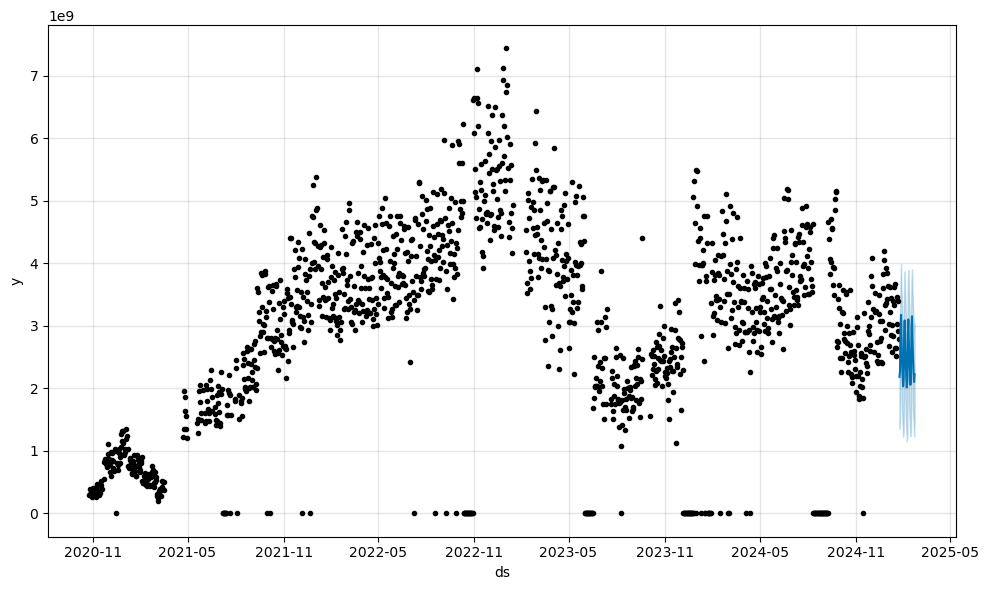

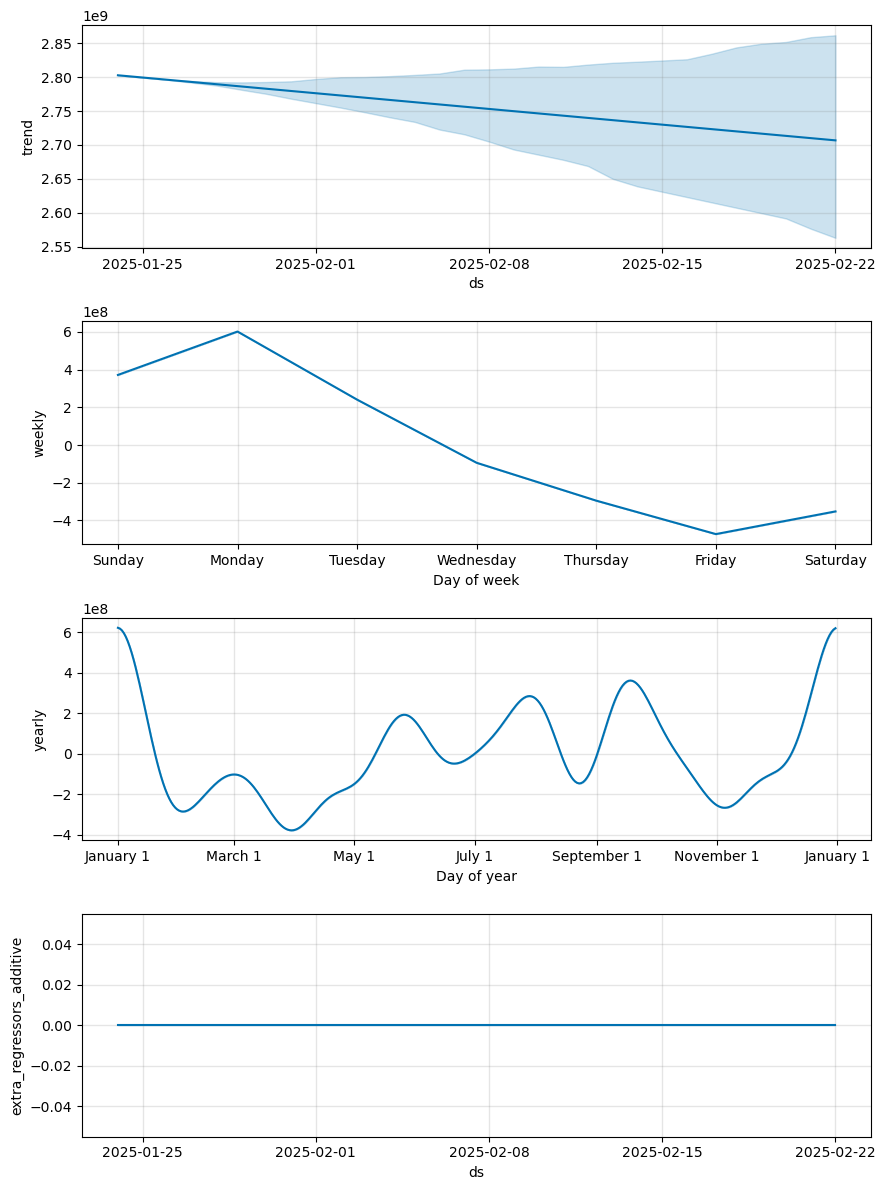

In [69]:
# Predictions
future = m.make_future_dataframe(periods=30).tail(30)

for col in outlier_cols:
    future[col] = [0] * len(future)

forecast = m.predict(future)

fig1 = m.plot(forecast)

fig2 = m.plot_components(forecast)

In [70]:
# Undo-Box-Cox

# Load lam from ../Forecasts/Models/Prophet_lam.pkl
with open('../Forecasts/Models/Prophet_lam.pkl', 'rb') as f:
    lam = pickle.load(f)

forecast['yhat'] = inv_boxcox(forecast['yhat'], lam)
forecast['yhat_lower'] = inv_boxcox(forecast['yhat_lower'], lam)
forecast['yhat_upper'] = inv_boxcox(forecast['yhat_upper'], lam)
# Add Date column
print(forecast)
print(df['Date'].max())
forecast['Date'] = [df['Date'].max() + pd.Timedelta(days=i) for i in range(1, 31)]
forecast

           ds         trend     yhat_lower    yhat_upper   trend_lower  \
0  2025-01-24  2.802628e+09  572039.341422  9.314509e+05  2.802628e+09   
1  2025-01-25  2.799324e+09  604606.511468  9.543657e+05  2.799324e+09   
2  2025-01-26  2.796019e+09  757789.047426  1.075201e+06  2.796019e+09   
3  2025-01-27  2.792715e+09  809770.091186  1.113038e+06  2.791746e+09   
4  2025-01-28  2.789410e+09  722859.722937  1.043422e+06  2.787433e+09   
5  2025-01-29  2.786106e+09  640653.703994  9.888908e+05  2.781239e+09   
6  2025-01-30  2.782801e+09  590314.779726  9.427621e+05  2.775295e+09   
7  2025-01-31  2.779497e+09  538114.549231  9.047907e+05  2.768140e+09   
8  2025-02-01  2.776193e+09  561529.234497  9.345439e+05  2.761597e+09   
9  2025-02-02  2.772888e+09  735435.751699  1.063266e+06  2.755036e+09   
10 2025-02-03  2.769584e+09  775991.456459  1.092551e+06  2.748050e+09   
11 2025-02-04  2.766279e+09  697819.382033  1.030650e+06  2.740670e+09   
12 2025-02-05  2.762975e+09  625169.31

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Outlier_2020-12-14 00:00:00,Outlier_2020-12-14 00:00:00_lower,Outlier_2020-12-14 00:00:00_upper,Outlier_2021-07-07 00:00:00,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Date
0,2025-01-24,2.802628e+09,572039.341422,9.314509e+05,2.802628e+09,2.802628e+09,0.0,0.0,0.0,0.0,...,-4.725061e+08,-4.725061e+08,-1.460493e+08,-1.460493e+08,-1.460493e+08,0.0,0.0,0.0,767839.374136,2025-02-24
1,2025-01-25,2.799324e+09,604606.511468,9.543657e+05,2.799324e+09,2.799324e+09,0.0,0.0,0.0,0.0,...,-3.522105e+08,-3.522105e+08,-1.736883e+08,-1.736883e+08,-1.736883e+08,0.0,0.0,0.0,787049.767302,2025-02-25
2,2025-01-26,2.796019e+09,757789.047426,1.075201e+06,2.796019e+09,2.796019e+09,0.0,0.0,0.0,0.0,...,3.716918e+08,3.716918e+08,-1.981866e+08,-1.981866e+08,-1.981866e+08,0.0,0.0,0.0,927888.894084,2025-02-26
3,2025-01-27,2.792715e+09,809770.091186,1.113038e+06,2.791746e+09,2.794201e+09,0.0,0.0,0.0,0.0,...,6.018178e+08,6.018178e+08,-2.194974e+08,-2.194974e+08,-2.194974e+08,0.0,0.0,0.0,966955.414518,2025-02-27
4,2025-01-28,2.789410e+09,722859.722937,1.043422e+06,2.787433e+09,2.792444e+09,0.0,0.0,0.0,0.0,...,2.406781e+08,2.406781e+08,-2.376219e+08,-2.376219e+08,-2.376219e+08,0.0,0.0,0.0,893391.151747,2025-02-28
5,2025-01-29,2.786106e+09,640653.703994,9.888908e+05,2.781239e+09,2.792136e+09,0.0,0.0,0.0,0.0,...,-9.435845e+07,-9.435845e+07,-2.526066e+08,-2.526066e+08,-2.526066e+08,0.0,0.0,0.0,821928.048240,2025-03-01
6,2025-01-30,2.782801e+09,590314.779726,9.427621e+05,2.775295e+09,2.792722e+09,0.0,0.0,0.0,0.0,...,-2.951128e+08,-2.951128e+08,-2.645386e+08,-2.645386e+08,-2.645386e+08,0.0,0.0,0.0,776277.300234,2025-03-02
7,2025-01-31,2.779497e+09,538114.549231,9.047907e+05,2.768140e+09,2.793744e+09,0.0,0.0,0.0,0.0,...,-4.725061e+08,-4.725061e+08,-2.735413e+08,-2.735413e+08,-2.735413e+08,0.0,0.0,0.0,734758.465809,2025-03-03
8,2025-02-01,2.776193e+09,561529.234497,9.345439e+05,2.761597e+09,2.797176e+09,0.0,0.0,0.0,0.0,...,-3.522105e+08,-3.522105e+08,-2.797689e+08,-2.797689e+08,-2.797689e+08,0.0,0.0,0.0,759172.723686,2025-03-04
9,2025-02-02,2.772888e+09,735435.751699,1.063266e+06,2.755036e+09,2.799767e+09,0.0,0.0,0.0,0.0,...,3.716918e+08,3.716918e+08,-2.834017e+08,-2.834017e+08,-2.834017e+08,0.0,0.0,0.0,906875.796709,2025-03-05


In [108]:
# Plot the actual data
actual_trace = go.Scatter(
    x=df['Date'],
    y=df['Revenue Losses'],
    mode='lines+markers',
    name='Actual Revenue Losses',
    hoverinfo='text',
    #hovertemplate="%{x|%a, %b %d, %Y}<br>Actual Revenue Losses<br>$%{y:,.0f}<extra></extra>",
    hovertext=[f"{date.strftime('%a, %b %d, %Y')}<br>Actual Revenue Losses<br>${revenue:,.0f}" for date, revenue in zip(df['Date'], df['Revenue Losses'])],
    line=dict(),
    legendrank=1
)

# Plot the forecast
forecast_trace = go.Scatter(
    x=forecast['Date'],
    y=forecast['yhat'],
    mode='lines+markers',
    name='Forecast',
    hoverinfo='text',
    #hovertemplate="%{x|%a, %b %d, %Y}<br>Forecast<br>$%{y:,.0f}<extra></extra>",
    hovertext=[f"{date.strftime('%a, %b %d, %Y')}<br>Forecast<br>${revenue:,.0f}" for date, revenue in zip(forecast['Date'], forecast['yhat'])],
    line=dict(dash='solid'),
    legendrank=2
)

# Plot the prediction interval as a shaded region
interval_trace = go.Scatter(
    x=forecast['Date'].tolist() + forecast['Date'][::-1].tolist(),
    y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Prediction Interval',
    hoverinfo='skip',
    #hoverinfo='text',
    #hovertext=[f"{date.strftime('%a, %b %d, %Y')}<br>95% Prediction Interval<br>(${lower:,.0f}, ${upper:,.0f})" for date, lower, upper in zip(forecast['Date'], forecast['yhat_lower'], forecast['yhat_upper'])],
    legendrank=3
)

# Create the figure
fig = go.Figure(data=[actual_trace, interval_trace, forecast_trace])

# Update layout for elegance
fig.update_layout(
    title='Revenue Losses and Forecast',
    template='none',
    hovermode='x unified',
    legend=dict(
        orientation='h',  # Horizontal
        x=0.5,            # Centered
        xanchor='center', # Centered
        y=-0.2,           # Below the plot area
        yanchor='top',
        traceorder='normal'
    ),
)

# Update y-axis for custom scaling
fig.update_yaxes(
    tickprefix="$",
    tickformat=".2s",  # Use "M" for millions and "K" for thousands
    tickfont=dict(size=12)
)

# Update x-axis for date format without day of the week
fig.update_xaxes(
    tickformat="%b %d, %Y",  # Month, day, and year (no day of the week)
    tickmode='auto',
    tickfont=dict(size=12)
)

fig.show()


